In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# -- Import some initial libraries
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from skimage.transform import resize
from PIL import Image
from sklearn.model_selection import train_test_split
#Don't show warning messages
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_csv = pd.read_csv('../input/sartorius-cell-instance-segmentation/train.csv', sep=',')
image_format = 'png'
# Define directories:
img_dir = '../input/sartorius-cell-instance-segmentation/train'
mask_dir = './masks'
if os.path.exists(mask_dir):
    shutil.rmtree(mask_dir)
os.makedirs(mask_dir)

## 1. Explore a bit the data:

In [5]:
## -- Look at the dataframe:
train_csv.sample(5)

id                                         annotation  width  \
35590  8122040d9ecd     363943 3 364644 9 364659 2 365347 18 366051 18    704   
4826   129f894abe35  201919 1 202622 1 203325 1 204028 1 204731 1 2...    704   
13265  309be9da24d7  93992 4 94695 6 95398 8 96100 10 96801 12 9749...    704   
30580  704f269a8415  106420 2 107122 8 107826 10 108530 11 109234 1...    704   
20505  48383b66ebd5  21722 3 22426 4 23131 5 23835 6 24540 6 25245 ...    704   

       height cell_type plate_time sample_date  \
35590     520    shsy5y  11h30m00s  2019-06-15   
4826      520     astro  13h00m00s  2020-09-15   
13265     520    shsy5y  11h30m00s  2019-06-14   
30580     520    shsy5y  11h30m00s  2019-06-16   
20505     520     astro  09h00m00s  2020-09-14   

                                 sample_id elapsed_timedelta  
35590   shsy5y[diff]_D11-1_Vessel-714_Ph_3   0 days 11:30:00  
4826     astro[hippo]_F2-2_Vessel-361_Ph_1   0 days 13:00:00  
13265    shsy5y[diff]_D7-3_Vessel-714_Ph_4   0 days 11:30:00  
30580    shsy5y[diff]_E8-2_Vessel-714_Ph_3   0 days 11:30:00  
20505  astros[cereb]_G11-3_Vessel-361_Ph_4   0 days 09:00:00

In [113]:
# -- Get the cell type
print(f"Cell types: {', '.join(cell for cell in train_csv['cell_type'].unique().tolist())}")

Cell types: shsy5y, astro, cort


In [104]:
# -- Get the shape of all images to see if there are unique
print(f"Height: {train_csv['height'].unique().tolist()}")
print(f"Width: {train_csv['width'].unique().tolist()}")

Height: [520]
Width: [704]


In [114]:
# -- Check if there are missing values:
train_csv.isna().sum()

id                   0
annotation           0
width                0
height               0
cell_type            0
plate_time           0
sample_date          0
sample_id            0
elapsed_timedelta    0
dtype: int64

In [124]:
# -- Check the number of cells per cell type
(
train_csv
    .groupby('cell_type')
    .agg(num_cell = ('id','count'))
)  

num_cell
cell_type          
astro         10522
cort          10777
shsy5y        52286

In [128]:
# -- Check the number of images per cell type:
for cell in train_csv['cell_type'].unique().tolist():
    num_imgs = len(train_csv.query("cell_type == @cell")['id'].unique())
    print(f'For {cell} there are {num_imgs} images.')
                               

For shsy5y there are 155 images.
For astro there are 131 images.
For cort there are 320 images.


**To summarise, this dataset consist in images of astrocytes, cortical neurons and the shsy5y cell line. All images have the same shape (520x704) and a corresponding rle that will require to be decoded in order to recover the mask and train the Deep learning model. There is an imbalance in the total number of cells present between the 3 different cell types, as well as the number of images available (probably to try to compensate for the scarcity of some cells within an image**

In [7]:
# The images all have the same shape  so let's define a variable for that:
shape = [520, 704]

In [8]:
# -- Get the list of img files
files = []
for r, d, f in os.walk(img_dir):
    for fil in f:
        if(image_format):
            if fil.endswith(image_format):
                files.append(os.path.join(r,fil))
        else:
            files.append(os.path.join(r,fil))

if(len(files)==0):
    print("Number of images loaded: %d." %(len(files)))
    print("Cannot read image files. Check if folder has images")
else:
    print("Number of images loaded: %d." %(len(files)))

Number of images loaded: 606.


In [12]:
# Here some function to decode rle since there is no mask
import tensorflow as tf
def getId(file_list):
    id_file = []
    for file in file_list:
        id_file.append(file.split('/')[-1].split('.')[0])
    return id_file

def rle_decode(mask_rle, shape = shape):
    '''
    Input [string]: Run-length encoded pixel mask
    Output [tf.array of shape shape]: Segmentation mask
    '''
    shape = tf.convert_to_tensor(shape, tf.int64)
    size = tf.math.reduce_prod(shape)
    # Split string
    s = tf.strings.split(mask_rle)
    s = tf.strings.to_number(s, tf.int64)
    # Get starts and lengths
    starts = s[::2] - 1
    lens = s[1::2]
    # Make ones to be scattered
    total_ones = tf.reduce_sum(lens)
    ones = tf.ones([total_ones], tf.uint8)
    # Make scattering indices
    r = tf.range(total_ones)
    lens_cum = tf.math.cumsum(lens)
    s = tf.searchsorted(lens_cum, r, 'right')
    idx = r + tf.gather(starts - tf.pad(lens_cum[:-1], [(1, 0)]), s)
    # Scatter ones into flattened mask
    mask_flat = tf.scatter_nd(tf.expand_dims(idx, 1), ones, [size])
    # Reshape into mask
    return tf.reshape(mask_flat, shape)

def createMask(img_id_list):
    parent_dir = '/kaggle/working/'
    mask_dir = os.path.join(parent_dir, 'masks')
    if os.path.exists(mask_dir):
        shutil.rmtree(mask_dir)
    os.makedirs(mask_dir)
        
    for img_id in img_id_list:
        shape = [train_csv.loc[train_csv.id == img_id, 'height'].tolist()[0], train_csv.loc[train_csv.id == img_id, 'width'].tolist()[0]]
        mask = np.zeros(shape).astype(float)
        buffer = 0. * mask
        for idx, row in train_csv[train_csv.id == img_id].iterrows():
            # decode the mask
            buffer = rle_decode(row.annotation, shape).numpy().astype(float)
            mask += buffer
        mask[mask > 0] = 1
        mask[mask == 0] = np.nan
        mask_name = img_id+"_masks.png"
        im = Image.fromarray(mask)
        im = im.convert("L")
        im.save(os.path.join(mask_dir, mask_name))



In [13]:
# Create the mask since this will be required to train the ML model:
createMask(getId(files))

In [15]:
# Save the masks directory in case the kernel is crashing
!zip -r masks.zip "/kaggle/working"

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/masks/ (stored 0%)
  adding: kaggle/working/masks/4de92f67c5b8_masks.png (stored 0%)
  adding: kaggle/working/masks/563435d64260_masks.png (deflated 5%)
  adding: kaggle/working/masks/e9edcd9483e4_masks.png (deflated 3%)
  adding: kaggle/working/masks/4551bb9de3fa_masks.png (stored 0%)
  adding: kaggle/working/masks/d5c06777eee7_masks.png (deflated 1%)
  adding: kaggle/working/masks/73df2962444f_masks.png (stored 0%)
  adding: kaggle/working/masks/875775b0a33f_masks.png (deflated 0%)
  adding: kaggle/working/masks/e96b5ddfef20_masks.png (stored 0%)
  adding: kaggle/working/masks/0e9b40b10de8_masks.png (deflated 4%)
  adding: kaggle/working/masks/cca71932b689_masks.png (stored 0%)
  adding: kaggle/working/masks/026b3c2c4b32_masks.png (deflated 3%)
  adding: kaggle/working/masks/2c2cb870da85_masks.png (stored 0%)
  adding: kaggle/working/masks/b81db12284ff_masks.png (deflated 8%)
  adding: kaggle/working/masks/48a750fc02a2_ma

In [ ]:
# -- Let's have a look at random images and mask per cells:
def displayImgCell():
    
    # First get the cell types:
    cell_type = train_csv['cell_type'].unique().tolist()
    img_ids = train_csv['id'].unique().tolist()
    # Then loop through the cell types to get an example:
    for cell in cell_type:
        cell_ids = train_csv.loc[train_csv.id.isin(img_ids),].query('cell_type == @cell')['id'].unique().tolist()
        idx = np.random.randint(0,len(cell_ids))
        img = train_imgs[idx]
        true_mask = train_masks[idx]
        
        # Plot the image:
        fig = plt.figure(figsize=(16,6), clear = True)
        plt.subplot(121)
        plt.imshow(img, cmap='seismic')
        plt.title('Image of '+ cell)
        
        plt.subplot(122)
        plt.imshow(true_mask, cmap='YlGn_r')
        plt.title('Mask for '+ cell)
        plt.show()
        plt.close()

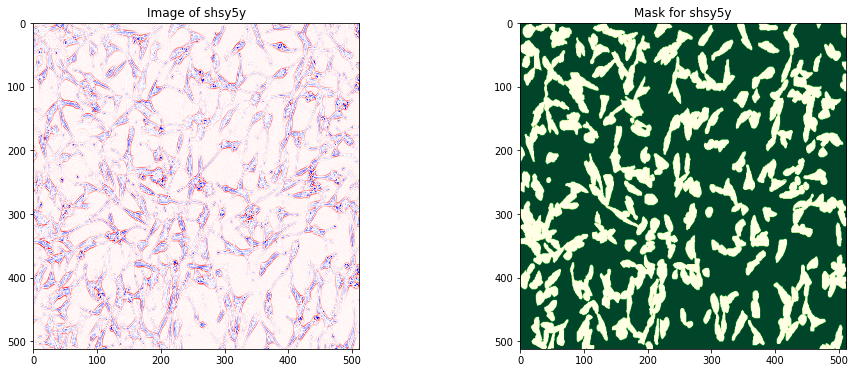

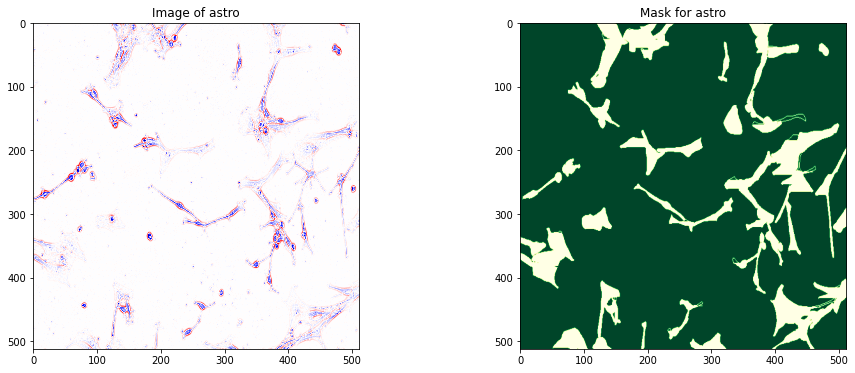

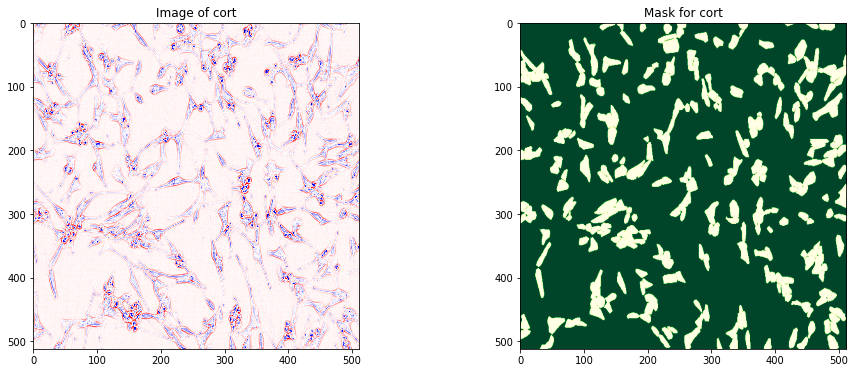

In [143]:
displayImgCell()

In [18]:
# Create train and validation dataset
from sklearn.model_selection import train_test_split
all_ids = train_csv['id'].unique().tolist()

train_ids, val_ids = train_test_split(all_ids, test_size=0.15, random_state=42)
print(f'all ids: {len(all_ids)}, train ids: {len(train_ids)}, val ids: {len(val_ids)}.')

all ids: 606, train ids: 515, val ids: 91.


In [17]:
# Check if all cell types are represented
all_cells = train_csv['cell_type'].unique().tolist()
train_cells = train_csv.loc[train_csv['id'].isin(train_ids), 'cell_type'].unique().tolist()
val_cells = train_csv.loc[train_csv['id'].isin(val_ids),'cell_type'].unique().tolist()
print(f'all cell types: {all_cells}, train cell types: {train_cells}, val cell types: {val_cells}.')

all cell types: ['shsy5y', 'astro', 'cort'], train cell types: ['shsy5y', 'astro', 'cort'], val cell types: ['cort', 'shsy5y', 'astro'].


In [19]:
# Check number of cells per cell type for the whole dataset:
(
train_csv
    .groupby('cell_type')
    .agg(num_cell = ('id','count'))
)


num_cell
cell_type          
astro         10522
cort          10777
shsy5y        52286

In [20]:
# Check number of cells per cell type for the train dataset:
(
train_csv
    .query('id in @train_ids')
    .groupby('cell_type')
    .agg(num_cell = ('id','count'))
)

num_cell
cell_type          
astro          8540
cort           9332
shsy5y        44166

In [21]:
# Check number of cells per cell type for the test dataset:
(
train_csv
    .query('id in @val_ids')
    .groupby('cell_type')
    .agg(num_cell = ('id','count'))
)

num_cell
cell_type          
astro          1982
cort           1445
shsy5y         8120

In [22]:
import tensorflow_addons as tfa
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras import backend as K

In [23]:
# preprocessing
def img_color_rescale(img):
    return(img-tf.reduce_mean(img)/128)

def img_load(img_id, directory='train'):
    img_dir = ('/kaggle/input/sartorius-cell-instance-segmentation/%s/' % directory)
    img = tf.keras.utils.load_img(img_dir+img_id+'.png', color_mode = 'grayscale')
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = resize(img, (512, 512, 1), mode='constant', preserve_range=True)
    return img

def mask_load(img_id, directory='masks'):
    mask_dir = ('/kaggle/working/%s/' % directory)
    mask = tf.keras.utils.load_img(mask_dir+img_id+'_masks.png', color_mode = 'grayscale')
    mask = tf.keras.preprocessing.image.img_to_array(mask)
    mask = resize(mask, (512, 512, 1), mode='constant', preserve_range=True)
    return mask

In [25]:
# Load images and masks

train_imgs = []
for img_id in train_ids:
    img = img_load(img_id)
    train_imgs.append(img_color_rescale(img).numpy())
train_imgs = np.array(train_imgs)

val_imgs = []
for img_id in val_ids:
    img = img_load(img_id)
    val_imgs.append(img_color_rescale(img).numpy())
val_imgs = np.array(val_imgs)

train_masks = []
for img_id in train_ids:
    img = mask_load(img_id)
    train_masks.append(img)
train_masks = np.array(train_masks)

val_masks = []
for img_id in val_ids:
    img = mask_load(img_id)
    val_masks.append(img)
val_masks = np.array(val_masks)

In [26]:
# Reshape images to be square and see if everything is in the right format, i.e (num_img, width, height, channel)
print(f'shape train imgs: {train_imgs.shape}, shape val imgs: {val_imgs.shape}, shape train masks: {train_masks.shape}, shape val masks: {val_masks.shape}.')

shape train imgs: (515, 512, 512, 1), shape val imgs: (91, 512, 512, 1), shape train masks: (515, 512, 512, 1), shape val masks: (91, 512, 512, 1).


477


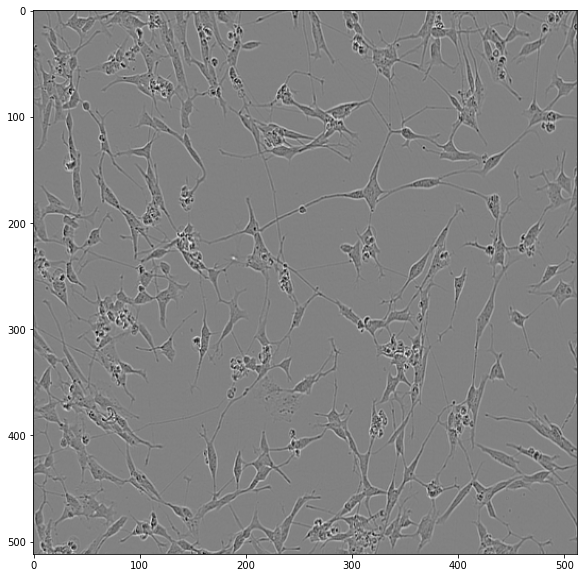

In [28]:
# Check if everything is allright regarding the training data:
idx = np.random.randint(0,len(train_ids))
fig = plt.figure(figsize=(10,10), clear=True)
ax = plt.gca()
ax.imshow(train_imgs[idx],cmap='gray');
print(idx)

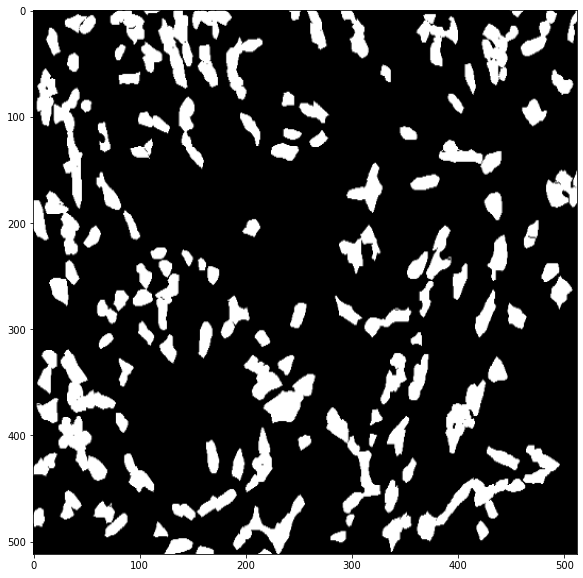

In [29]:
fig = plt.figure(figsize=(10,10), clear=True)
ax = plt.gca()
ax.imshow(train_masks[idx],cmap='gray');

In [30]:
# Metrics definition:
def dice_coef(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou
    
def iou_coef_loss(y_true, y_pred):
    return -iou(y_true, y_pred)

In [31]:
# Build model 1 without augmentation

def getUnetModel():
    inputs = Input((512, 512, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    #model.compile(optimizer=Adam(lr=1e-5), loss=iou_coef_loss, metrics=[iou])
    #model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

    return model


In [32]:
model1 = getUnetModel()
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [33]:
model1_stopper = EarlyStopping(patience=10, verbose = 1)
model1_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', verbose = 1, save_best_only=True)

In [34]:
history = model1.fit(
    tf.cast(train_imgs, tf.float32).numpy(),
    tf.cast(tf.expand_dims(train_masks,axis=3),tf.float32).numpy(),
    validation_data=(
        tf.cast(val_imgs, tf.float32).numpy(),
        tf.cast(tf.expand_dims(val_masks, axis=3), tf.float32).numpy()),
        batch_size=1,epochs = 100, callbacks=[model1_stopper, model1_checkpoint], verbose=1)

2022-02-09 07:35:00.599565: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-02-09 07:35:02.606179: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


515/515 [==============================] - 30s 43ms/step - loss: -0.2187 - dice_coef: 0.2187 - val_loss: -0.3033 - val_dice_coef: 0.3033

Epoch 00001: val_loss improved from inf to -0.30333, saving model to weights.h5
Epoch 2/100
515/515 [==============================] - 22s 43ms/step - loss: -0.3165 - dice_coef: 0.3165 - val_loss: -0.3551 - val_dice_coef: 0.3551

Epoch 00002: val_loss improved from -0.30333 to -0.35507, saving model to weights.h5
Epoch 3/100
515/515 [==============================] - 22s 43ms/step - loss: -0.4202 - dice_coef: 0.4202 - val_loss: -0.4252 - val_dice_coef: 0.4252

Epoch 00003: val_loss improved from -0.35507 to -0.42519, saving model to weights.h5
Epoch 4/100
515/515 [==============================] - 22s 43ms/step - loss: -0.5002 - dice_coef: 0.5002 - val_loss: -0.5305 - val_dice_coef: 0.5305

Epoch 00004: val_loss improved from -0.42519 to -0.53049, saving model to weights.h5
Epoch 5/100
515/515 [==============================] - 22s 42ms/step - loss: 

In [35]:
def plot_history (history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')
   # plt.gca().set_yscale('log')
    plt.show()
    plt.close()

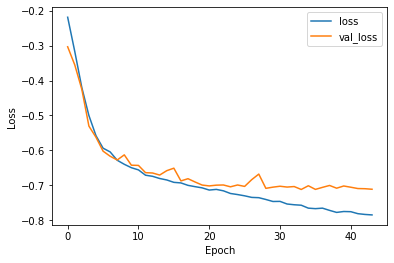

In [36]:
plot_history(history)

In [37]:
model1.save('model_1.h5')

### Metrics for competition:

In [38]:
# IoU

def compute_iou(labels, y_pred):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    iou = intersection / union
    
    return iou[1:, 1:]  # exclude background

# Precision
def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array [n_truths x n_preds]): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

# Overall Metric
def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [compute_iou(truth, pred) for truth, pred in zip(truths, preds)]
    
    print(ious[0].shape)

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)


In [39]:
# Check the prediction of the model:
def display_predict(model):
    idx = np.random.randint(0,len(train_ids))
    img = train_imgs[idx]
    true_mask = train_masks[idx]
    pred_mask = model.predict(img.reshape((1,512,512,1)))[0]
    
    # Plot the prediction
    fig = plt.figure(figsize=(16,6), clear = True)
    
    plt.subplot(131)
    plt.imshow(img, cmap='seismic')
    plt.title('Image')
    
    plt.subplot(132)
    plt.imshow(pred_mask, cmap='YlGn_r')
    plt.title('Model Prediction')
    
    plt.subplot(133)
    plt.imshow(true_mask, cmap='YlGn_r')
    plt.title('True Mask')
    plt.show()
    plt.close()
    


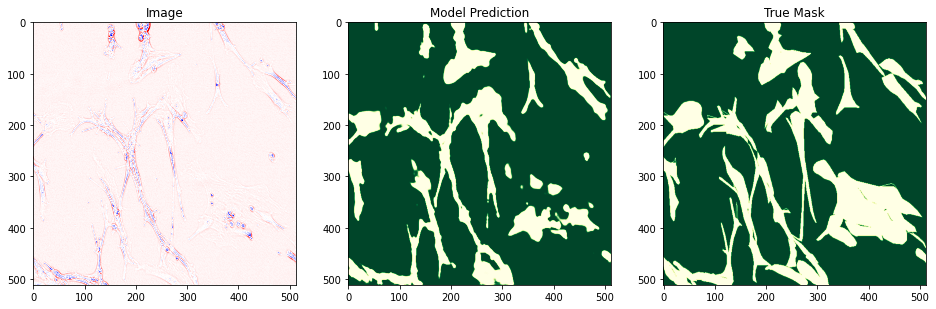

In [40]:
display_predict(model1)

### Let's do with some augmentation to see if the model is a bit better

In [41]:
# Function that will change a bit the images and the corresponding images:
def img_mask_augment(img, mask):
    # Concatenate alongs channel to process both the image and the mask with the same operation
    composite = tf.concat([img, mask], axis=3)
    
    # Define here the augmentation methods:
    composite = layers.RandomTranslation(
        height_factor = (-1,1),
        width_factor = (-1,1),
        fill_mode = 'wrap'
    )(composite)
    composite = layers.RandomZoom(
        height_factor=(-0.4, 0.2),
        fill_mode = 'wrap'
    )(composite)
    composite = layers.RandomRotation(
        factor=(-1,1),
        fill_mode = 'wrap'
    )(composite)
    composite = layers.RandomFlip()(composite)
    
    # Split the composite image to get back the img and the mask respectively
    img = tf.expand_dims(composite[:,:,:,0], axis=3)
    mask = tf.expand_dims(composite[:,:,:,1], axis=3)
    del composite
    return img, mask


In [42]:
# To use the augmentation, one needs to overwrite the fitting method, see: https://keras.io/guides/customizing_what_happens_in_fit/
class AugmentedData(keras.Sequential):
    def train_step(self, data):
        # read the data passed to fit()
        img, mask = data
        # augment
        img, mask = img_mask_augment(img, mask)
        # perform the augmentation and turn into tensors
        img, mask = tf.constant(img.numpy()), tf.constant(mask.numpy())
        
        # then return the modified img and mask
        return super().train_step((img,mask))


In [43]:
# Define Unet model with augmentation:

def getUnetAugmented():
    # First pass the augmentation and the run the model as previously
    AugmentedData()
    inputs = Input((512, 512, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [44]:
model2 = getUnetAugmented()
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 512, 512, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 32) 9248        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [45]:
model2_stopper = EarlyStopping(patience=10, verbose = 1)
model2_checkpoint = ModelCheckpoint('weights_2.h5', monitor='val_loss', verbose = 1, save_best_only=True)

In [46]:
history2 = model2.fit(
    tf.cast(train_imgs, tf.float32).numpy(),
    tf.cast(tf.expand_dims(train_masks,axis=3),tf.float32).numpy(),
    validation_data=(
        tf.cast(val_imgs, tf.float32).numpy(),
        tf.cast(tf.expand_dims(val_masks, axis=3), tf.float32).numpy()),
        batch_size=1,epochs = 100, callbacks=[model2_stopper, model2_checkpoint], verbose=1)

Epoch 1/100
515/515 [==============================] - 24s 44ms/step - loss: -0.1690 - dice_coef: 0.1690 - val_loss: -0.1887 - val_dice_coef: 0.1887

Epoch 00001: val_loss improved from inf to -0.18874, saving model to weights_2.h5
Epoch 2/100
515/515 [==============================] - 22s 43ms/step - loss: -0.1711 - dice_coef: 0.1711 - val_loss: -0.1889 - val_dice_coef: 0.1889

Epoch 00002: val_loss improved from -0.18874 to -0.18887, saving model to weights_2.h5
Epoch 3/100
515/515 [==============================] - 22s 42ms/step - loss: -0.1711 - dice_coef: 0.1711 - val_loss: -0.1889 - val_dice_coef: 0.1889

Epoch 00003: val_loss improved from -0.18887 to -0.18889, saving model to weights_2.h5
Epoch 4/100
515/515 [==============================] - 22s 42ms/step - loss: -0.1711 - dice_coef: 0.1711 - val_loss: -0.1889 - val_dice_coef: 0.1889

Epoch 00004: val_loss improved from -0.18889 to -0.18892, saving model to weights_2.h5
Epoch 5/100
515/515 [==============================] - 22

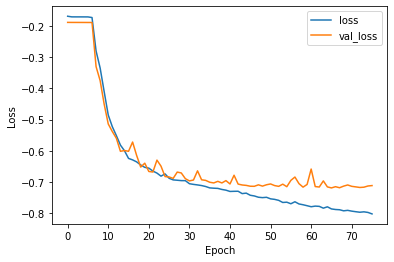

In [47]:
plot_history(history2)

In [48]:
model2.save('model_2.h5')

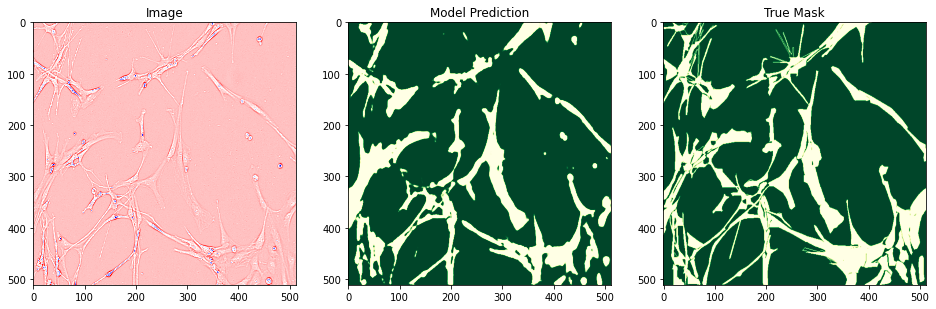

In [49]:
display_predict(model2)

### Test with simpler model just to see...

In [50]:
import keras_tuner as kt
from tensorflow import keras

In [60]:
def getModel_tuner(hp):
    # First pass the augmentation and the run the model as previously
    AugmentedData()
    inputs = Input((512, 512, 1))
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv2 = Conv2D(8, (5, 5), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(8, (7, 7), activation='relu', padding='same')(pool1)
    conv4 = Conv2D(8, (1,1), activation='relu', padding='same')(conv3)
    conv5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    dense1 = Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                  activation='relu')(conv4)
    dense2 = Dense(10, activation='softmax')(dense1)

    model = Model(inputs=[inputs], outputs=[dense2])
    
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [70]:
def getSimpleModel():
    AugmentedData()
    inputs = Input((512, 512, 1))
    conv1 = Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    conv2 = Conv2D(8, (5,5), activation='relu', padding='same')(conv1)
    conv3 = Conv2D(8, (7,7), activation='relu', padding='same')(conv2)
    conv4 = Conv2D(8, (1,1), activation='relu', padding='same')(conv3)
    conv5 = Conv2D(1, (1,1), activation='sigmoid', padding='same')(conv4)
    
    model = Model(inputs=[inputs], outputs=[conv5])
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    return model

In [71]:
model3 = getSimpleModel()
model3.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 512, 512, 16)      160       
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 512, 512, 8)       3208      
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 512, 512, 8)       3144      
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 512, 512, 8)       72        
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 512, 512, 1)       9         
Total params: 6,593
Trainable params: 6,593
Non-trainable params: 0
_________________________________________________________

In [72]:
model3_stopper = EarlyStopping(patience=10, verbose = 1)
model3_checkpoint = ModelCheckpoint('weights_3.h5', monitor='val_loss', verbose = 1, save_best_only=True)

In [78]:
history3 = model3.fit(
    tf.cast(train_imgs, tf.float32).numpy(),
    tf.cast(tf.expand_dims(train_masks,axis=3),tf.float32).numpy(),
    validation_data=(
        tf.cast(val_imgs, tf.float32).numpy(),
        tf.cast(tf.expand_dims(val_masks, axis=3), tf.float32).numpy()),
        batch_size=1,epochs = 500, callbacks=[model3_stopper, model3_checkpoint], verbose=1)

Epoch 1/500
515/515 [==============================] - 11s 21ms/step - loss: -0.4613 - dice_coef: 0.4613 - val_loss: -0.4375 - val_dice_coef: 0.4375

Epoch 00001: val_loss did not improve from -0.43821
Epoch 2/500
515/515 [==============================] - 10s 19ms/step - loss: -0.4619 - dice_coef: 0.4619 - val_loss: -0.4407 - val_dice_coef: 0.4407

Epoch 00002: val_loss improved from -0.43821 to -0.44066, saving model to weights_3.h5
Epoch 3/500
515/515 [==============================] - 10s 20ms/step - loss: -0.4624 - dice_coef: 0.4624 - val_loss: -0.4427 - val_dice_coef: 0.4427

Epoch 00003: val_loss improved from -0.44066 to -0.44266, saving model to weights_3.h5
Epoch 4/500
515/515 [==============================] - 10s 20ms/step - loss: -0.4637 - dice_coef: 0.4637 - val_loss: -0.4429 - val_dice_coef: 0.4429

Epoch 00004: val_loss improved from -0.44266 to -0.44294, saving model to weights_3.h5
Epoch 5/500
515/515 [==============================] - 10s 20ms/step - loss: -0.4636 - 

In [79]:
model3.save('model_3.h5')

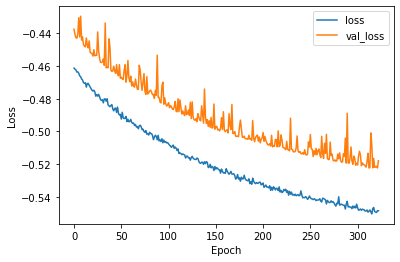

In [80]:
plot_history(history3)

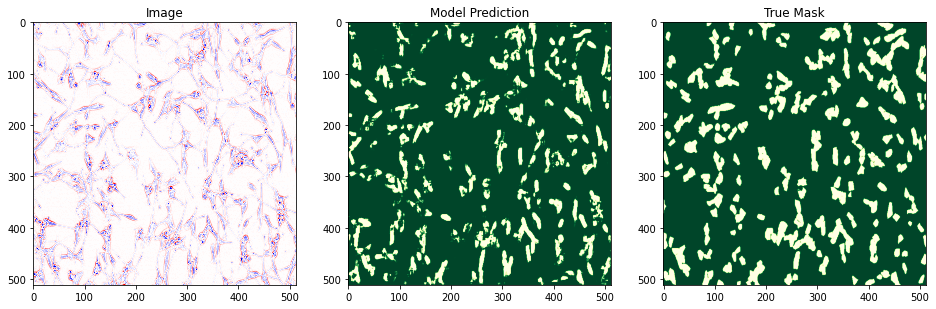

In [81]:
display_predict(model3)

In [115]:
# Make the function to encode the mask into rle to compete dataframe:
def rle_encode(mask):
    """
    mask: numpy array with 1 = mask and 0 = background
    Returns rle as string formatted
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels,[0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0]+1
    runs[1::2] -=runs[::2]
    return ' '.join(str(x) for x in runs)

In [99]:
# -- Function to display example for each cell type:
def display_predict_cells(model):
    
    # First get the cell types:
    cell_type = train_csv['cell_type'].unique().tolist()
    
    # Then loop through the cell types to get an example:
    for cell in cell_type:
        cell_ids = train_csv.loc[train_csv.id.isin(train_ids),].query('cell_type == @cell')['id'].unique().tolist()
        idx = np.random.randint(0,len(cell_ids))
        img = train_imgs[idx]
        true_mask = train_masks[idx]
        pred_mask = model.predict(img.reshape((1,512,512,1)))[0]
        
        # Plot the prediction:
        fig = plt.figure(figsize=(16,6), clear = True)
        plt.subplot(131)
        plt.imshow(img, cmap='seismic')
        plt.title('Image of '+ cell)
        
        plt.subplot(132)
        plt.imshow(pred_mask, cmap='YlGn_r')
        plt.title('Model Prediction for '+ cell)
        
        plt.subplot(133)
        plt.imshow(true_mask, cmap='YlGn_r')
        plt.title('True Mask for '+ cell)
        plt.show()
        plt.close()
    
    

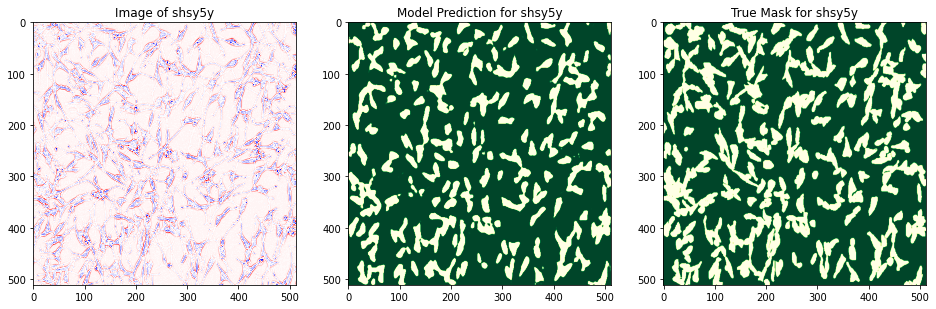

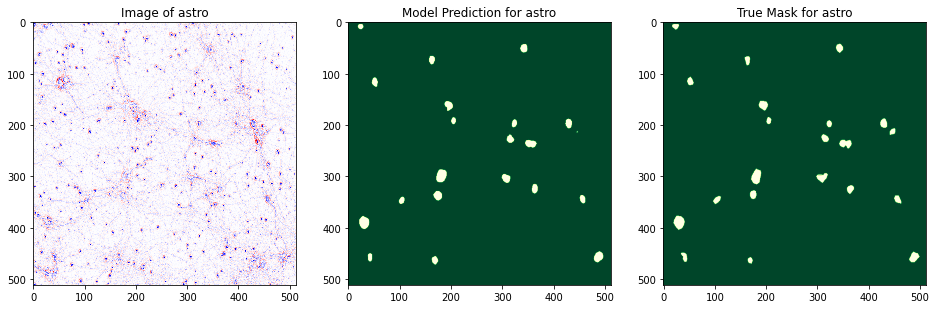

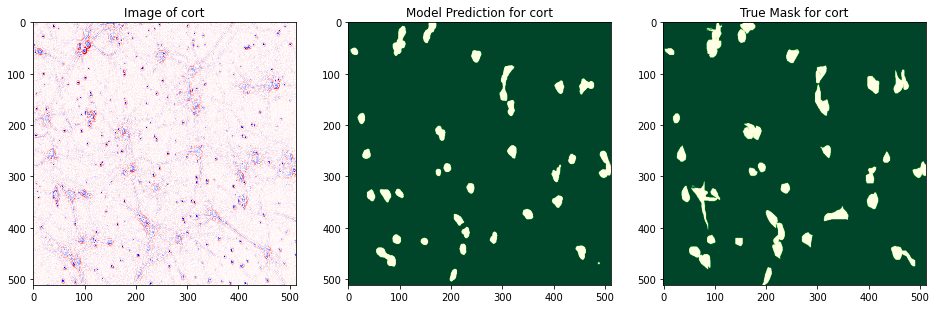

In [100]:
display_predict_cells(model1)

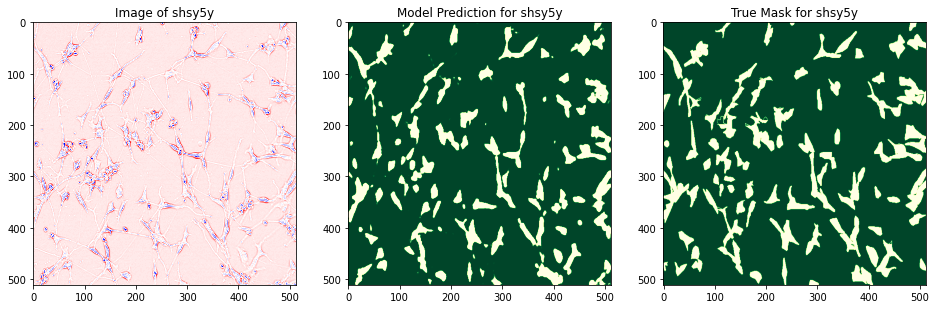

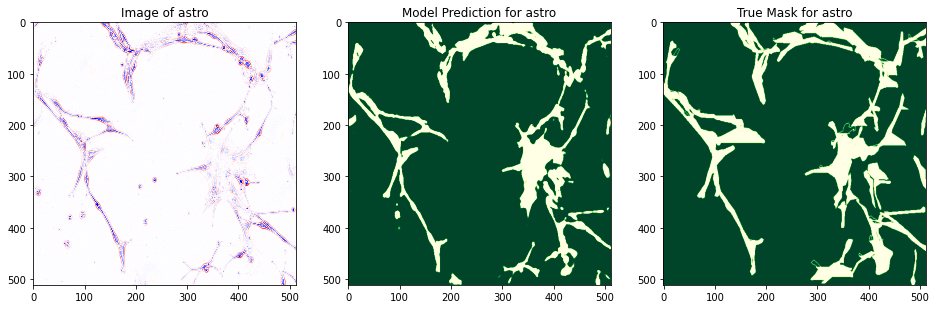

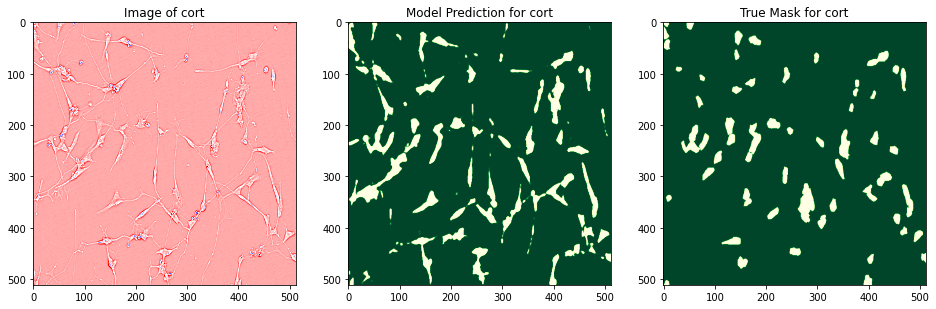

In [121]:
display_predict_cells(model2)

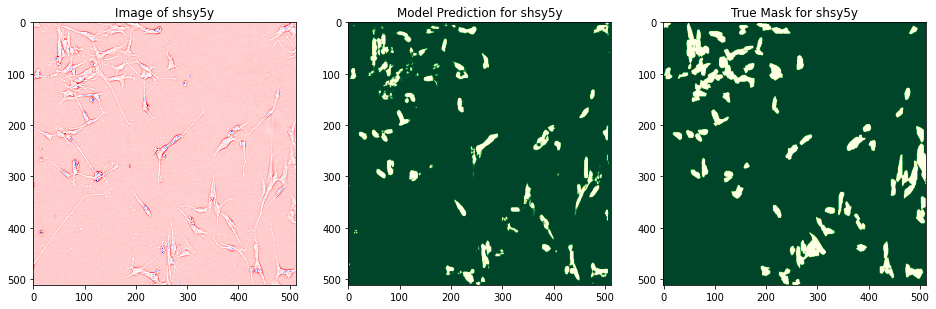

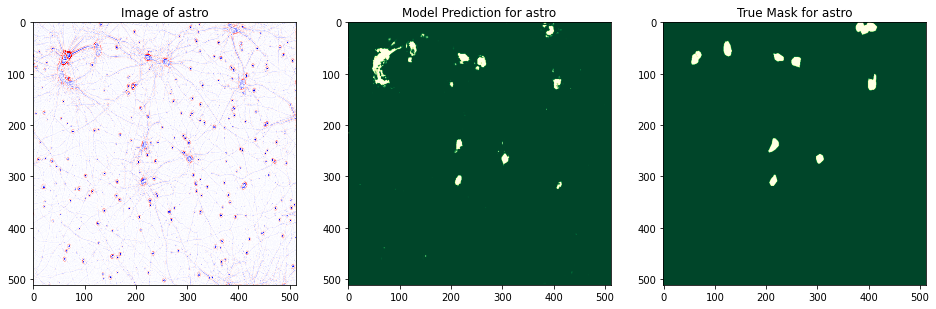

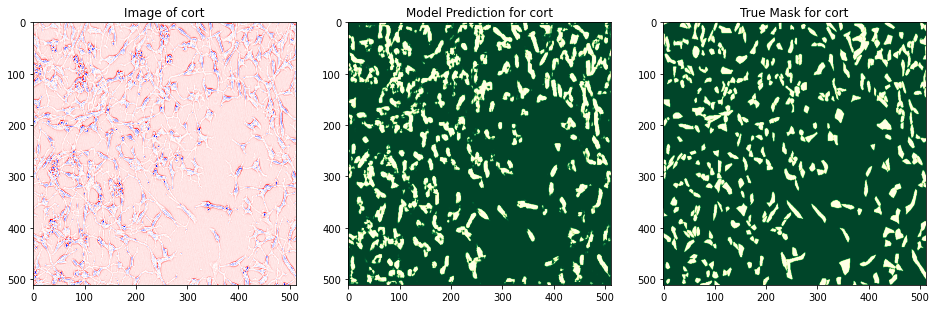

In [102]:
display_predict_cells(model3)